# Building a data analyst agent with LangGraph and Azure Container Apps dynamic sessions

In this example we'll build an agent that can query a Postgres database and run Python code to analyze the retrieved data. We'll use [LangGraph](https://langchain-ai.github.io/langgraph/) for agent orchestration and [Azure Container Apps dynamic sessions](https://python.langchain.com/v0.2/docs/integrations/tools/azure_dynamic_sessions/) for safe Python code execution.

**NOTE**: Building LLM systems that interact with SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your agent's needs. This will mitigate though not eliminate the risks of building a model-driven system. For more on general security best practices, see our [security guidelines](https://python.langchain.com/v0.2/docs/security/).

## Setup

Let's get set up by installing our Python dependencies and setting our OpenAI credentials, Azure Container Apps sessions pool endpoint, and our SQL database connection string.

### Install dependencies

In [20]:
%pip install -qU langgraph langchain-azure-dynamic-sessions langchain-openai langchain-community pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


### Set credentials

By default this demo uses:
- Azure OpenAI for the model: https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource
- Azure PostgreSQL for the db: https://learn.microsoft.com/en-us/cli/azure/postgres/server?view=azure-cli-latest#az-postgres-server-create
- Azure Container Apps dynamic sessions for code execution: https://learn.microsoft.com/en-us/azure/container-apps/sessions-code-interpreter?

This LangGraph architecture can also be used with any other [tool-calling LLM](https://python.langchain.com/v0.2/docs/how_to/tool_calling) and any SQL database.

In [21]:
import getpass
import os

os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Azure OpenAI API key")
os.environ["AZURE_OPENAI_ENDPOINT"] = getpass.getpass("Azure OpenAI endpoint")

AZURE_OPENAI_DEPLOYMENT_NAME = getpass.getpass("Azure OpenAI deployment name")
SESSIONS_POOL_MANAGEMENT_ENDPOINT = getpass.getpass(
    "Azure Container Apps dynamic sessions pool management endpoint"
)
SQL_DB_CONNECTION_STRING = getpass.getpass("PostgreSQL connection string")

Azure OpenAI API key ········
Azure OpenAI endpoint ········
Azure OpenAI deployment name ········
Azure Container Apps dynamic sessions pool management endpoint ········
PostgreSQL connection string ········


### Imports

In [22]:
import ast
import base64
import io
import json
import operator
from functools import partial
from typing import Annotated, List, Literal, Optional, Sequence, TypedDict

import pandas as pd
from IPython.display import display
from langchain_azure_dynamic_sessions import SessionsPythonREPLTool
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode
from matplotlib.pyplot import imshow
from PIL import Image

## Instantiate model, DB, code interpreter

We'll use the LangChain [SQLDatabase](https://python.langchain.com/v0.2/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html#langchain_community.utilities.sql_database.SQLDatabase) interface to connect to our DB and query it. This works with any SQL database supported by [SQLAlchemy](https://www.sqlalchemy.org/).

In [23]:
db = SQLDatabase.from_uri(SQL_DB_CONNECTION_STRING)

For our LLM we need to make sure that we use a model that supports [tool-calling](https://python.langchain.com/v0.2/docs/how_to/tool_calling).

In [24]:
llm = AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME, openai_api_version="2024-02-01"
)

And the [dynamic sessions tool](https://python.langchain.com/v0.2/docs/integrations/tools/azure_container_apps_dynamic_sessions/) is what we'll use for code execution.

In [25]:
repl = SessionsPythonREPLTool(
    pool_management_endpoint=SESSIONS_POOL_MANAGEMENT_ENDPOINT
)

## Define graph

Now we're ready to define our application logic. The core elements are the [agent State, Nodes, and Edges](https://langchain-ai.github.io/langgraph/concepts/#core-design).

### Define State
We'll use a simple agent State which is just a list of messages that every Node can append to:

In [31]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

Since our code interpreter can return results like base64-encoded images which we don't want to pass back to the model, we'll create a custom Tool message that allows us to track raw Tool outputs without sending them back to the model.

In [32]:
class RawToolMessage(ToolMessage):
    """
    Customized Tool message that lets us pass around the raw tool outputs (along with string contents for passing back to the model).
    """

    raw: dict
    """Arbitrary (non-string) tool outputs. Won't be sent to model."""
    tool_name: str
    """Name of tool that generated output."""

### Define Nodes

First we'll define a node for calling our model. We need to make sure to bind our tools to the model so that it knows to call them. We'll also specify in our prompt the schema of the SQL tables the model has access to, so that it can write relevant SQL queries.

We'll use our models tool-calling abilities to reliably generate our SQL queries and Python code. To do this we need to define schemas for our tools that the model can use for structuring its tool calls.

Note that the class names, docstrings, and attribute typing and descriptions are crucial here, as they're actually passed in to the model (you can effectively think of them as part of the prompt).

In [33]:
# Tool schema for querying SQL db
class create_df_from_sql(BaseModel):
    """Execute a PostgreSQL SELECT statement and use the results to create a DataFrame with the given column names."""

    select_query: str = Field(..., description="A PostgreSQL SELECT statement.")
    # We're going to convert the results to a Pandas DataFrame that we pass
    # to the code intepreter, so we also have the model generate useful column and
    # variable names for this DataFrame that the model will refer to when writing
    # python code.
    df_columns: List[str] = Field(
        ..., description="Ordered names to give the DataFrame columns."
    )
    df_name: str = Field(
        ..., description="The name to give the DataFrame variable in downstream code."
    )


# Tool schema for writing Python code
class python_shell(BaseModel):
    """Execute Python code that analyzes the DataFrames that have been generated. Make sure to print any important results."""

    code: str = Field(
        ...,
        description="The code to execute. Make sure to print any important results.",
    )

In [34]:
system_prompt = f"""\
You are an expert at PostgreSQL and Python. You have access to a PostgreSQL database \
with the following tables

{db.table_info}

Given a user question related to the data in the database, \
first get the relevant data from the table as a DataFrame using the create_df_from_sql tool. Then use the \
python_shell to do any analysis required to answer the user question."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("placeholder", "{messages}"),
    ]
)


def call_model(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    chain = prompt | llm.bind_tools([create_df_from_sql, python_shell])
    messages.append(chain.invoke({"messages": state["messages"]}))

    return {"messages": messages}

Now we can define the node for executing any SQL queries that were generated by the model. Notice that after we run the query we convert the results into Pandas DataFrames — these will be uploaded the the code interpreter tool in the next step so that it can use the retrieved data.

In [35]:
def execute_sql_query(state: AgentState) -> dict:
    """Execute the latest SQL queries."""
    messages = []

    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] != "create_df_from_sql":
            continue

        # Execute SQL query
        res = db.run(tool_call["args"]["select_query"], fetch="cursor").fetchall()

        # Convert result to Pandas DataFrame
        df_columns = tool_call["args"]["df_columns"]
        df = pd.DataFrame(res, columns=df_columns)
        df_name = tool_call["args"]["df_name"]

        # Add tool output message
        messages.append(
            RawToolMessage(
                f"Generated dataframe {df_name} with columns {df_columns}",  # What's sent to model.
                raw={df_name: df},
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )

    return {"messages": messages}

Now we need a node for executing any model-generated Python code. The key steps here are:
- Uploading queried data to the code intepreter
- Executing model generated code
- Parsing results so that images are displayed and not passed in to future model calls

To upload the queried data to the model we can take our DataFrames we generated by executing the SQL queries and upload them as CSVs to our code intepreter.

In [36]:
def _upload_dfs_to_repl(state: AgentState) -> str:
    """
    Upload generated dfs to code intepreter and return code for loading them.

    Note that code intepreter sessions are short-lived so this needs to be done
    every agent cycle, even if the dfs were previously uploaded.
    """
    df_dicts = [
        msg.raw
        for msg in state["messages"]
        if isinstance(msg, RawToolMessage) and msg.tool_name == "create_df_from_sql"
    ]
    name_df_map = {name: df for df_dict in df_dicts for name, df in df_dict.items()}

    # Data should be uploaded as a BinaryIO.
    # Files will be uploaded to the "/mnt/data/" directory on the container.
    for name, df in name_df_map.items():
        buffer = io.StringIO()
        df.to_csv(buffer)
        buffer.seek(0)
        repl.upload_file(data=buffer, remote_file_path=name + ".csv")

    # Code for loading the uploaded files.
    df_code = "import pandas as pd\n" + "\n".join(
        f"{name} = pd.read_csv('/mnt/data/{name}.csv')" for name in name_df_map
    )
    return df_code


def _repl_result_to_msg_content(repl_result: dict) -> str:
    """
    Display images with including them in tool message content.
    """
    content = {}
    for k, v in repl_result.items():
        # Any image results are returned as a dict of the form:
        # {"type": "image", "base64_data": "..."}
        if isinstance(repl_result[k], dict) and repl_result[k]["type"] == "image":
            # Decode and display image
            base64_str = repl_result[k]["base64_data"]
            img = Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))
            display(img)
        else:
            content[k] = repl_result[k]
    return json.dumps(content, indent=2)


def execute_python(state: AgentState) -> dict:
    """
    Execute the latest generated Python code.
    """
    messages = []

    df_code = _upload_dfs_to_repl(state)
    last_ai_msg = [msg for msg in state["messages"] if isinstance(msg, AIMessage)][-1]
    for tool_call in last_ai_msg.tool_calls:
        if tool_call["name"] != "python_shell":
            continue

        generated_code = tool_call["args"]["code"]
        repl_result = repl.execute(df_code + "\n" + generated_code)

        messages.append(
            RawToolMessage(
                _repl_result_to_msg_content(repl_result),
                raw=repl_result,
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )
    return {"messages": messages}

### Define Edges

Now we're ready to put all the pieces together into a graph.

In [37]:
def should_continue(state: AgentState) -> str:
    """
    If any Tool messages were generated in the last cycle that means we need to call the model again to interpret the latest results.
    """
    return "execute_sql_query" if state["messages"][-1].tool_calls else END

In [38]:
workflow = StateGraph(AgentState)

workflow.add_node("call_model", call_model)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("execute_python", execute_python)

workflow.set_entry_point("call_model")
workflow.add_edge("execute_sql_query", "execute_python")
workflow.add_edge("execute_python", "call_model")
workflow.add_conditional_edges("call_model", should_continue)

app = workflow.compile()

In [39]:
print(app.get_graph().draw_ascii())

                                       +-----------+                                    
                                       | __start__ |                                    
                                       +-----------+                                    
                                              *                                         
                                              *                                         
                                              *                                         
                                       +------------+                                   
                                    ...| call_model |***                                
                             .......   +------------+   *******                         
                     ........          ..           ...        *******                  
              .......                ..                ...            ******            
          ....       

## Test it out

Replace these examples with questions related to the database you've connected your agent to.

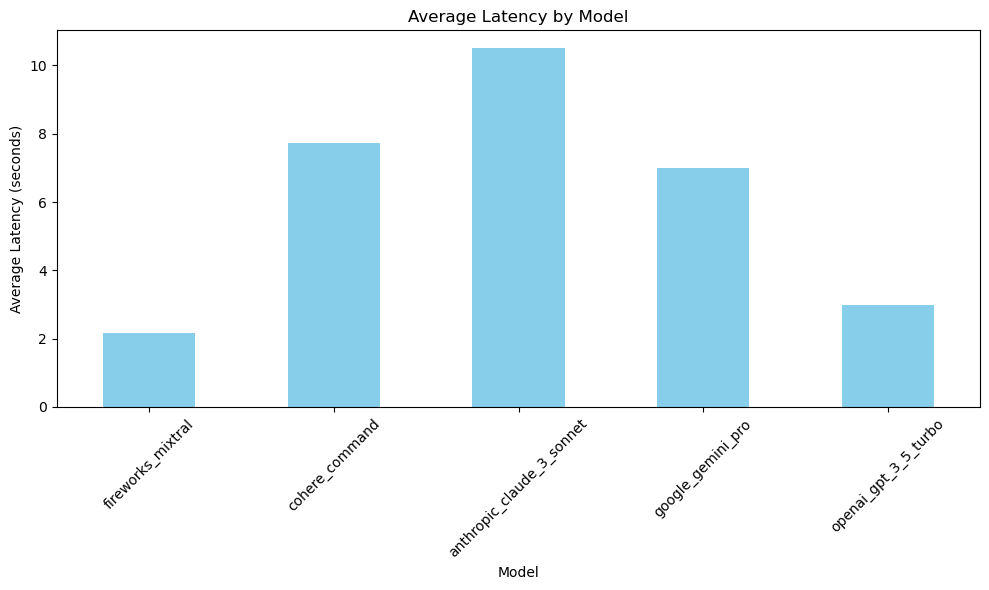

The graph of the average latency by model has been generated successfully. However, it seems that the output is not displayed here directly. To view the graph, you would typically run the provided Python code in an environment where graphical output is supported, such as a Jupyter notebook or a Python script executed in a local environment with access to a display server.


In [40]:
output = app.invoke({"messages": [("human", "graph the average latency by model")]})
print(output["messages"][-1].content)

**LangSmith Trace**: https://smith.langchain.com/public/9c8afcce-0ed1-4fb1-b719-767e6432bd8e/r

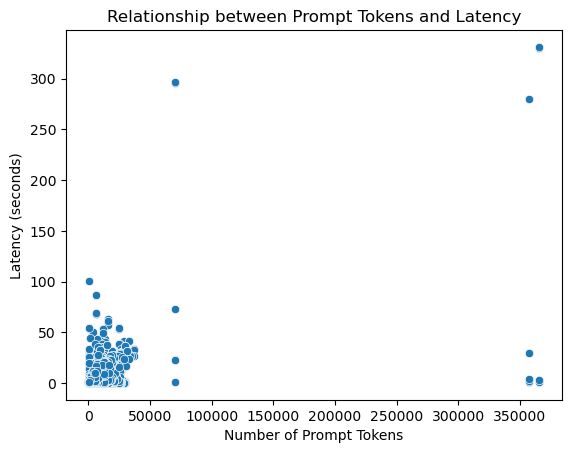

The correlation coefficient between the number of prompt tokens and latency is approximately 0.305, indicating a positive but relatively weak relationship. This suggests that as the number of input tokens increases, there tends to be an increase in latency, but the relationship is not strong and other factors may also influence latency.

Here is the scatter plot showing the relationship visually:

![Scatter Plot of Prompt Tokens and Latency](sandbox:/2)


In [41]:
output = app.invoke(
    {
        "messages": [
            ("human", "what's the relationship between latency and input tokens?")
        ]
    }
)
print(output["messages"][-1].content)

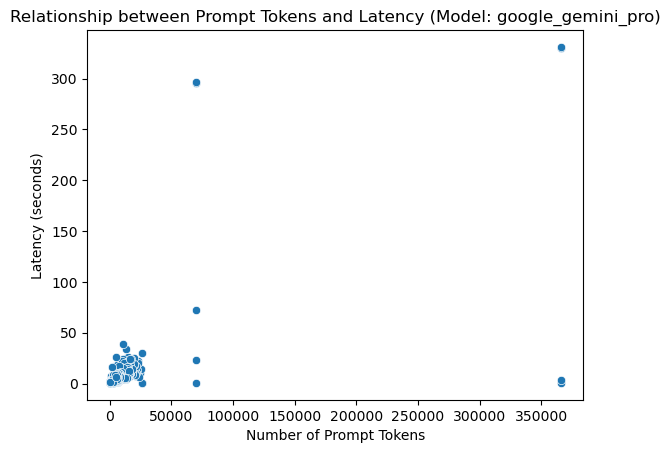

In [43]:
# Continue the conversation
output = app.invoke(
    {"messages": output["messages"] + [("human", "now control for model")]}
)

In [44]:
print(output["messages"][-1].content)

After controlling for each model, here are the individual correlations between prompt tokens and latency:

- `anthropic_claude_3_sonnet`: Correlation = 0.7659
- `openai_gpt_3_5_turbo`: Correlation = 0.2833
- `fireworks_mixtral`: Correlation = 0.1673
- `cohere_command`: Correlation = 0.1434
- `google_gemini_pro`: Correlation = 0.4928

These correlations indicate that the `anthropic_claude_3_sonnet` model has the strongest positive correlation between the number of prompt tokens and latency, while the `cohere_command` model has the weakest positive correlation.

Scatter plots were generated for each model individually to illustrate the relationship between prompt tokens and latency. Below are the plots for each model:

1. Model: anthropic_claude_3_sonnet
![Scatter Plot for anthropic_claude_3_sonnet](sandbox:/2)

2. Model: openai_gpt_3_5_turbo
![Scatter Plot for openai_gpt_3_5_turbo](sandbox:/2)

3. Model: fireworks_mixtral
![Scatter Plot for fireworks_mixtral](sandbox:/2)

4. Model: cohe

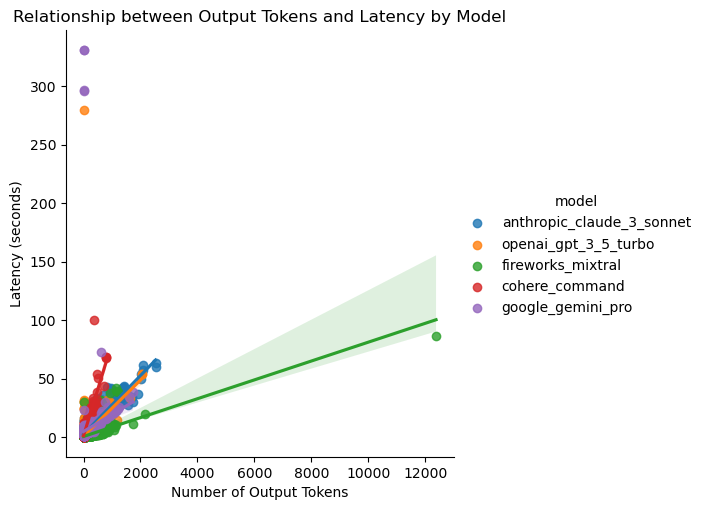

In [46]:
output = app.invoke(
    {
        "messages": output["messages"]
        + [("human", "what about latency vs output tokens")]
    }
)

In [47]:
print(output["messages"][-1].content)

The correlation between the number of output tokens (completion_tokens) and latency varies by model, as shown below:

- `anthropic_claude_3_sonnet`: Correlation = 0.910274
- `cohere_command`: Correlation = 0.910292
- `fireworks_mixtral`: Correlation = 0.681286
- `google_gemini_pro`: Correlation = 0.151549
- `openai_gpt_3_5_turbo`: Correlation = 0.449127

The `anthropic_claude_3_sonnet` and `cohere_command` models show a very strong positive correlation, indicating that an increase in the number of output tokens is associated with a substantial increase in latency for these models. The `fireworks_mixtral` model also shows a strong positive correlation, but less strong than the first two. The `google_gemini_pro` model shows a weak positive correlation, and the `openai_gpt_3_5_turbo` model shows a moderate positive correlation.

Below is the scatter plot with a regression line showing the relationship between output tokens and latency for each model:

![Scatter Plot with Regression Line f

In [48]:
output = app.invoke(
    {
        "messages": [
            (
                "human",
                "what's the better explanatory variable for latency: input or output tokens?",
            )
        ]
    }
)

In [49]:
print(output["messages"][-1].content)

The correlation between input tokens and latency is 0.305, while the correlation between output tokens and latency is 0.487. Therefore, the better explanatory variable for latency is output tokens.
